# Exploratory Data Analysis

The work in this notebook focuses on standard flow of understanding and processing the dataset. The goal is to verify data quality and explore the features and their relationships. The desired output of this phase is a cleaned dataset ready for ML model training.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

The OmniAnomaly SMD dataset is unlabeled, originally intended for unsupervised analysis. That means, that for supervised learning I can use only the labeled test part and create my own time-consistent train/val/test partitions. I did a quick initial analysis that showed, that their labeled testing dataset contains >28k rows with >2.5k incident instances. This is still enough for both training and testing my model, so instead of looking for a new dataset, I'll simply split the original testing data by 70/30 ratio for my training and testing purposes. 

In [2]:
# Load the Data
data = pd.read_csv('../data/machine-1-1.txt', header=None)
labels = pd.read_csv('../data/machine-1-1-label.txt', header=None)

# Rename Columns for Clarity
feature_names = [f"feat_{i}" for i in range(data.shape[1])]
data.columns = feature_names
labels.columns = ['label']

# Combine into one DataFrame
full_df = pd.concat([data, labels], axis=1)

# Split into Train and Test Sets
train_size = int(len(full_df) * 0.70)
train_df = full_df.iloc[:train_size].reset_index(drop=True)
test_df  = full_df.iloc[train_size:].reset_index(drop=True)

# Quick Verification
print(f"Total Rows: {len(full_df)}")
print(f"Train Rows: {len(train_df)} | Incidents in Train: {train_df['label'].sum()}")
print(f"Test Rows:  {len(test_df)}  | Incidents in Test:  {test_df['label'].sum()}")

Total Rows: 28479
Train Rows: 19935 | Anomalies in Train: 2125
Test Rows:  8544  | Anomalies in Test:  569


## Univariate analysis

First, I'll check if there are any missing values. Since this is an already processed dataset from the OmniAnomaly project, I assume there shouldn't be any, but just in case.

In [3]:
# Check for Missing Values
missing_values = train_df.isnull().sum().sum()

print(f"Total Missing Values in Training Data: {missing_values}")

Total Missing Values in Training Data: 0


No missing values - good. Next, I'll look at some basic descriptive statistics.

In [4]:
train_df.describe()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,label
count,19935.000000,19935.000000,19935.000000,19935.000000,19935.0,19935.000000,19935.000000,19935.0,19935.000000,19935.000000,...,19935.000000,19935.000000,19935.000000,19935.000000,19935.000000,19935.000000,19935.000000,19935.0,19935.0,19935.000000
mean,0.141158,0.108112,0.107501,0.106281,0.0,0.917373,0.250663,0.0,0.023567,0.001171,...,0.016802,0.097339,0.072008,0.001070,0.000937,0.106631,0.106676,0.0,0.0,0.106596
std,0.139622,0.106150,0.106329,0.108161,0.0,0.028951,0.081416,0.0,0.018159,0.017392,...,0.029541,0.095390,0.073146,0.023508,0.024205,0.105629,0.105622,0.0,0.0,0.308607
min,0.010753,0.001059,0.004459,0.008130,0.0,0.351282,0.005650,0.0,0.000000,0.000000,...,0.004298,0.010819,0.009264,0.000000,0.000011,0.015420,0.015492,0.0,0.0,0.000000
25%,0.064516,0.046610,0.049052,0.047619,0.0,0.900000,0.241996,0.0,0.013483,0.000000,...,0.008596,0.044997,0.034483,0.000000,0.000022,0.049048,0.049081,0.0,0.0,0.000000
50%,0.096774,0.078390,0.079153,0.077816,0.0,0.910256,0.269303,0.0,0.024127,0.000122,...,0.011461,0.074710,0.053011,0.000386,0.000034,0.078839,0.078905,0.0,0.0,0.000000
75%,0.150538,0.129237,0.118172,0.112660,0.0,0.925641,0.282486,0.0,0.031223,0.000244,...,0.018625,0.102470,0.074112,0.000386,0.000045,0.112358,0.112350,0.0,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000


The data seem to have been Min-Max scaled. There are multiple features that seem to have no other value then zero. The output is truncated, so there could be even more features like this.

In [5]:
zero_variance_cols_train = train_df.columns[(train_df == 0).all()]
zero_variance_cols_test = test_df.columns[(test_df == 0).all()]

print(zero_variance_cols_test)
print(zero_variance_cols_train)


Index(['feat_4', 'feat_7', 'feat_16', 'feat_17', 'feat_26', 'feat_36',
       'feat_37'],
      dtype='str')
Index(['feat_4', 'feat_7', 'feat_16', 'feat_17', 'feat_36', 'feat_37'], dtype='str')


There are 6 features that have no values in both test and train parts of the dataset. Feature 26 is interesting, because it has no values in the testing part, but seems to have some in the training part. I'll take a closer look at it.

In [6]:
# Check unique values and their counts for 'feat_26'
unique_values_feat26 = train_df['feat_26'].value_counts().sort_index()
print("\nUnique values and their counts for 'feat_26' (Train):")
display(unique_values_feat26)


Unique values and their counts for 'feat_26' (Train):


feat_26
0.000000    19913
0.058824        1
0.117647        3
0.176471        3
0.235294        2
0.470588        1
0.588235        1
0.647059        1
0.705882        3
0.764706        1
0.823529        4
0.882353        1
1.000000        1
Name: count, dtype: int64

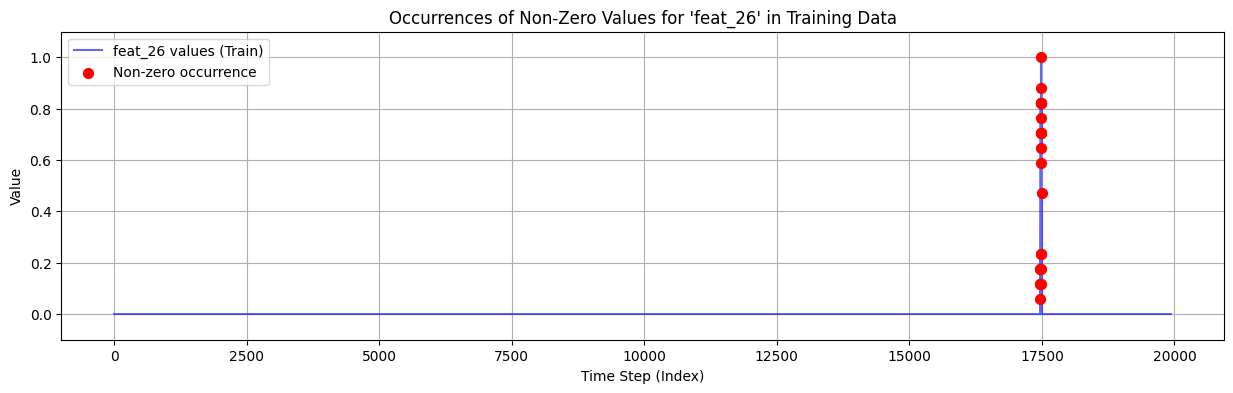

In [7]:
feat_26_series_train = train_df['feat_26']

# Identify indices where 'feat_26' is not zero
non_zero_indices_train = feat_26_series_train[feat_26_series_train != 0].index

plt.figure(figsize=(15, 4))
# Plot the entire series 
plt.plot(feat_26_series_train.index, feat_26_series_train.values, 
         alpha=0.6, label='feat_26 values (Train)', color='blue')

# Highlight the non-zero occurrences as distinct points
if len(non_zero_indices_train) > 0:
    plt.scatter(non_zero_indices_train, feat_26_series_train[non_zero_indices_train], 
                color='red', s=50, zorder=5, label='Non-zero occurrence')
    
plt.title("Occurrences of Non-Zero Values for 'feat_26' in Training Data")
plt.xlabel("Time Step (Index)")
plt.ylabel("Value")
plt.ylim(-0.1, 1.1) 
plt.grid(True)
plt.legend()
plt.show()

The fact that all the non-zero values of this feature are clustered together indicates, that some specific rare event could have happened at that time, or maybe a bug or configuration error happened and was quickly fixed. While this could be an important marker for incidents in the real cloud environment, feat_26 will provide no information during the evaluation period of my model on this dataset, because it has no values in the testing data. Same goes for the other features, that have no non-zero values. Perhaps in real environment they could have their importance, but for the purposes of this project they have no meaning.

In [8]:
cols_to_drop = ["feat_4", "feat_7", "feat_16", "feat_17", "feat_26", "feat_36", "feat_37"]

train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

print(f"New Training Data Shape: {train_df.shape}")
print(f"New Test Data Shape:     {test_df.shape}")

New Training Data Shape: (19935, 32)
New Test Data Shape:     (8544, 32)


### Visualization

In [ ]:
print("\n--- Histograms for all Features in Taining Data (Overview) ---")
train_df.hist(figsize=(20, 15), bins=30)
plt.suptitle("Histograms of All Remaining Features in Training Data", y=1.02) 
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [ ]:
print("\n--- Histograms for all Features in Testing Data (Overview) ---")
test_df.hist(figsize=(20, 15), bins=30)
plt.suptitle("Histograms of All Remaining Features in Training Data", y=1.02) 
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

There still seem to be some features in both the training and testing data, that have mostly zero values and only a few non-zero instances. These however, cannot be dropped, because they have non-zero occurences in both training and testing data. They could represent some event-driven metrics that only gain values when a specific event occurs and therefore might be indicative of incidents.

## Bivariate analysis

Next, I'll examine how each feature behaves in relation to the incident label. This should help identify potential early warning signals.

In [1]:
features_df = train_df.drop(columns=['label'], errors='ignore')
n_features = features_df.shape[1]
feature_names = features_df.columns.tolist()

# Grid of Time-Series Plots for all Features vs. Incidents
print(f"\n--- Grid Plots: All {n_features} Features vs. Incident Timeline ---")

num_cols = 4 
num_rows = (n_features + num_cols - 1) // num_cols 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 2), sharex=True)
axes = axes.flatten() 

for i, feature in enumerate(feature_names):
    ax = axes[i]
    
    ax.plot(features_df.index, features_df[feature], label=f'{feature} Value', alpha=0.7, color='blue', linewidth=0.5)
    
    anomaly_occurrence_points = np.where(train_df['label'] == 1, features_df[feature], np.nan)
    ax.plot(features_df.index, anomaly_occurrence_points, 'o', color='red', markersize=2, label='Incident (Label=1)', alpha=0.6)
    
    ax.set_title(f'{feature}', fontsize=8)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("All Features' Values vs. Incident Periods in Training Data", y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
plt.show()

NameError: name 'train_df' is not defined

The plots seem to support the previous assumption about event-driven indicators. Features, such as 33, 32, 29 and more, that have mostly zero values, seem to have strong correlation with incident instances during their peaks, making them strong indicators for incidents.

A key characteristic of this machine’s timeline is that incident labels are strongly concentrated toward the end of the series. This creates a practical issue for supervised time-series learning. A strict chronological split can leave the training period with limited exposure to incidents that appear later.

To reduce this bias and obtain a more diverse set of incident intervals for training and evaluation, I have decided to extend the dataset beyond a single machine and include the remaining machines from the same SMD Group 1.

In [11]:
import os
from pathlib import Path
import numpy as np
import pandas as pd


def load_smd_machine(data_dir: str, group_id: int, machine_id: int) -> pd.DataFrame:
    data_path = Path(data_dir) / f"machine-{group_id}-{machine_id}.txt"
    label_path = Path(data_dir) / f"machine-{group_id}-{machine_id}-label.txt"

    data = pd.read_csv(data_path, header=None)
    labels = pd.read_csv(label_path, header=None)

    data.columns = [f"feat_{i}" for i in range(data.shape[1])]
    labels.columns = ["label"]

    full_df = pd.concat([data, labels], axis=1)
    return full_df


DATA_DIR = "../data"
GROUP_ID = 1
MACHINE_IDS = range(1, 9) 

machines = {}
for mid in MACHINE_IDS:
    name = f"machine-{GROUP_ID}-{mid}"
    machines[name] = load_smd_machine(DATA_DIR, GROUP_ID, mid)

# Quick check
summary = []
for name, df in machines.items():
    
    has_missing = bool(df.isna().any().any())    
    summary.append(
        {
            "machine": name,
            "rows": len(df),
            "incidents": int(df["label"].sum()),
            "incident_rate": float(df["label"].mean()),
            "n_features": df.shape[1] - 1,
            "missing_values": "yes" if has_missing else "no",
        }
    )

summary_df = pd.DataFrame(summary).sort_values("machine")
summary_df

,machine,rows,anomalies,anomaly_rate,n_features,missing_values
0,machine-1-1,28479,2694,0.094596,38,no
1,machine-1-2,23694,542,0.022875,38,no
2,machine-1-3,23703,817,0.034468,38,no
3,machine-1-4,23707,720,0.030371,38,no
4,machine-1-5,23706,100,0.004218,38,no
5,machine-1-6,23689,3708,0.156528,38,no
6,machine-1-7,23697,2398,0.101194,38,no
7,machine-1-8,23699,763,0.032195,38,no


In [3]:
# Concatenate all feature rows across machines
all_features = pd.concat(
    [df.drop(columns=["label"]) for df in machines.values()],
    axis=0,
    ignore_index=True,
)

constant_cols = [
    col for col in all_features.columns if all_features[col].nunique(dropna=False) == 1
]

print(f"Constant features across ALL machines: {len(constant_cols)}")
print(constant_cols)

# Show which features are constant per machine
per_machine_constant = {}
for name, df in machines.items():
    feat_df = df.drop(columns=["label"])
    per_machine_constant[name] = [
        c for c in feat_df.columns if feat_df[c].nunique(dropna=False) == 1
    ]

per_machine_constant_df = pd.DataFrame(
    [{"machine": k, "n_constant": len(v), "constant_cols": v} for k, v in per_machine_constant.items()]
).sort_values("machine")

per_machine_constant_df

Constant features across ALL machines: 2
['feat_7', 'feat_37']


,machine,n_constant,constant_cols
0,machine-1-1,6,"[feat_4, feat_7, feat_16, feat_17, feat_36, fe..."
1,machine-1-2,5,"[feat_7, feat_26, feat_28, feat_36, feat_37]"
2,machine-1-3,4,"[feat_7, feat_26, feat_36, feat_37]"
3,machine-1-4,4,"[feat_7, feat_26, feat_36, feat_37]"
4,machine-1-5,8,"[feat_4, feat_7, feat_16, feat_17, feat_26, fe..."
5,machine-1-6,4,"[feat_7, feat_26, feat_28, feat_37]"
6,machine-1-7,4,"[feat_7, feat_26, feat_36, feat_37]"
7,machine-1-8,8,"[feat_4, feat_7, feat_16, feat_17, feat_26, fe..."


I also checked again if there is a feature that would be constant across all the machines. Found two features, these would have no impact on the training, so I'll drop them.

In [5]:
if constant_cols:
    for name in list(machines.keys()):
        machines[name] = machines[name].drop(columns=constant_cols)

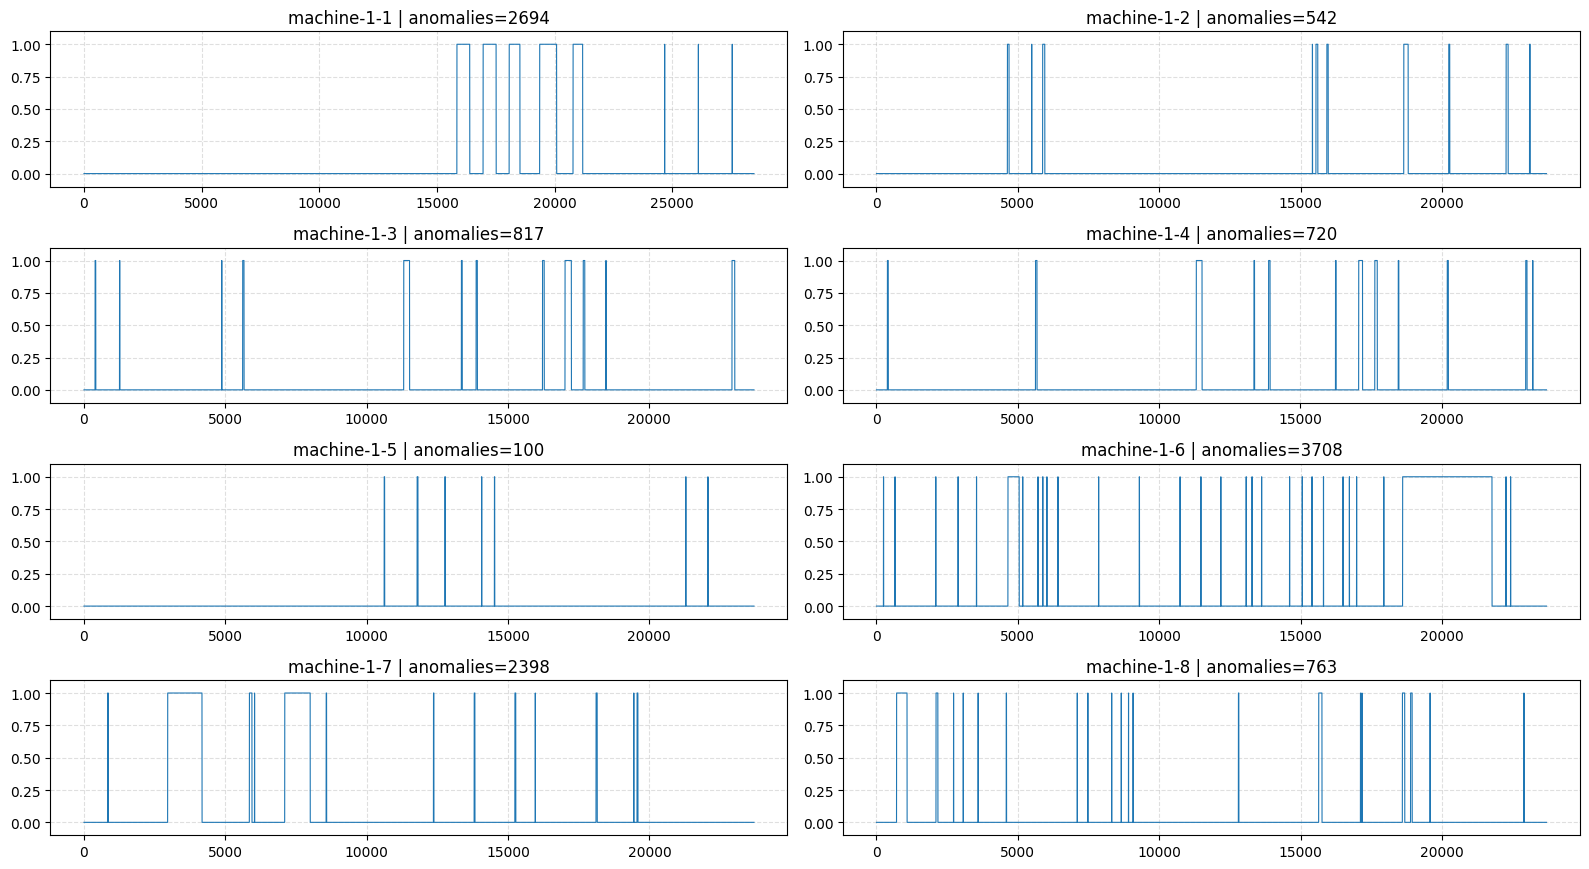

In [6]:
import matplotlib.pyplot as plt
import numpy as np


machine_names = list(machines.keys())
n = len(machine_names)
cols = 2
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 2.2 * rows), sharex=False)
axes = np.array(axes).reshape(-1)

for i, name in enumerate(machine_names):
    y = machines[name]["label"].to_numpy()
    x = np.arange(len(y))

    axes[i].plot(x, y, lw=0.8)
    axes[i].set_title(f"{name} | incidents={int(y.sum())}")
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].grid(True, linestyle="--", alpha=0.4)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Here it is clear that the other datasets have better spread of incidents. 

In [9]:
def save_df(df: pd.DataFrame, path_base: Path) -> None:
    try:
        df.to_parquet(path_base.with_suffix(".parquet"), index=False)
    except Exception:
        df.to_csv(path_base.with_suffix(".csv"), index=False)


OUT_DIR = Path("../data/processed/smd_group1")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for name, df in machines.items():
    save_df(df, OUT_DIR / name)

I store these final datasets to work with in the next stages of my project.